# FIBROSIS - LOGISTIC REGRESSION
Author: Nana K. Owusu

Purpose: To determine if the 95% confidence interval level for the
attenuation vs. shear stiffness predictors of the logistic regression models.

### Initial libraries

In [3]:
# from IPython import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
# import sys

# sys.path.append('C:\\Users\M257955\Documents\python')
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
from importlib import import_module, reload
from joblib import dump, load
from timeit import default_timer as timer
%matplotlib inline
ml_lib = import_module('ml_lib')

In [4]:
# ml_lib = reload(ml_lib)
from ml_lib import (roc_plot, classification_metrics, LOO_testing, fnr_cutoff,
                LOOwCO_testing, calc_auc, pearsonr_ci, spearmanr_ci, DeLong2_test,
                   export_as_excel)

### Getting and Cleaning the Data

In [5]:
#RAW DATA IMPORT
# data=pd.read_csv('nafld_cohort_60Hz.csv')
# data=pd.read_csv('../NAFLD-three-cohorts_20220411.csv')
data=pd.read_csv('../NAFLD-four-cohorts_20220413.csv')

In [6]:
# data.info()
# cols_2Dls = ['Cohort','ID','Steatosis','Inflammation',
#              'Ballooning','Fibrosis','PDFF','LS-2D-60']
cols_3Dmre = ['Steatosis','Inflammation','Ballooning',
              'NASH(0-1)','NASH(0-2)','NAS','Fibrosis','PDFF',
              'LS-3D-60','DR-3D-60','SM-3D-60', 'LM-3D-60']
# cols_3D60Hz = ['Cohort','ID','Steatosis','Inflammation',
#                'Ballooning','Fibrosis','PDFF',
#                'LS-3D-60','DR-3D-60','SM-3D-60',
#                'LM-3D-60']
# cols_nafld = ['ID','Age','Gender','NASH+F2','mu_SS','mu_AT',
#               'R2*','mu_VS','PDFF','floorFib','Fib_gt0','Fib_gt1',
#               'Fib_gt2','Fib_gt3','Lobular Inflammation', 
#               'Portal Inflammation']

In [7]:
#RENAMING COLUMNS
# data.rename({'Fibrosis-statistic':'floorFib'},axis=1, inplace=True)
# data=data.rename(columns=dict(zip(data.columns,new_names)))

#SELECTING RELEVANT COLUMNS
data=data[cols_3Dmre]

#REMOVING MISSING VALUES
data.dropna(inplace=True)

#ADDING TARGET COLUMNS
# data['Fibrosis'] = data['Fibrosis'].apply(lambda fib: int(np.fix(fib)))
# data['Fib_gt0'] = data['Fibrosis'].apply(lambda x: int(x>0))
data['Fib_gt1'] = data['Fibrosis'].apply(lambda x: int(x>1))
# data['Fib_gt2'] = data['Fibrosis'].apply(lambda x: int(x>2))
# data['Fib_gt3'] = data['Fibrosis'].apply(lambda x: int(x>3))
data['HRM'] = data['NASH(0-1)'].astype('int16') & data['Fib_gt1']

# data['Fib&Infl'] = data['Fibrosis'] + data['Inflammation']
# data['FI_gt0'] = data['Fib&Infl'].apply(lambda x: int(x>0))

# NASH
data['NASH_gt1'] = data['NASH(0-2)'].apply(lambda x: int(x>1))
data['NAS_gt0'] = data['NAS'].apply(lambda x: int(x>0))
data['NAS_gt1'] = data['NAS'].apply(lambda x: int(x>1))
data['NAS_gt2'] = data['NAS'].apply(lambda x: int(x>2))
data['NAS_gt3'] = data['NAS'].apply(lambda x: int(x>3))
data['NAS_gt4'] = data['NAS'].apply(lambda x: int(x>4))
data['NAS_gt5'] = data['NAS'].apply(lambda x: int(x>5))
data['NAS_gt6'] = data['NAS'].apply(lambda x: int(x>6))
data['NAS_gt7'] = data['NAS'].apply(lambda x: int(x>7))

data.rename({'LS-3D-60':'SS','DR-3D-60':'DR',
            'SM-3D-60':'SM','LM-3D-60':'LM',
            'NASH(0-1)':'NASH_gt0','NASH(0-2)':'NASH02'},axis=1, inplace=True)

# less = data[data['PDFF'] <= 8.1].copy()
# greater = data[data['PDFF'] > 8.1].copy()

#RESETTING INDEX
data.reset_index(drop=True, inplace=True)

In [8]:
data.to_excel('C:/Users/M257955/Desktop/cleaned_nafld_data.xlsx')

In [6]:
#SUMMARY
print('\nDATA TYPES:\n-----------')
print(data.dtypes)
print('\nMISSING VALUES:\n---------------')
print(data.isna().sum())
print('\nDIMENSIONS:\n---------------')
print(data.shape)
data.head()


DATA TYPES:
-----------
Steatosis       float64
Inflammation    float64
Ballooning      float64
NASH_gt0        float64
NASH02          float64
NAS             float64
Fibrosis        float64
PDFF            float64
SS              float64
DR              float64
SM              float64
LM              float64
NASH_gt1          int64
NAS_gt0           int64
NAS_gt1           int64
NAS_gt2           int64
NAS_gt3           int64
NAS_gt4           int64
NAS_gt5           int64
NAS_gt6           int64
NAS_gt7           int64
dtype: object

MISSING VALUES:
---------------
Steatosis       0
Inflammation    0
Ballooning      0
NASH_gt0        0
NASH02          0
NAS             0
Fibrosis        0
PDFF            0
SS              0
DR              0
SM              0
LM              0
NASH_gt1        0
NAS_gt0         0
NAS_gt1         0
NAS_gt2         0
NAS_gt3         0
NAS_gt4         0
NAS_gt5         0
NAS_gt6         0
NAS_gt7         0
dtype: int64

DIMENSIONS:
---------------
(379

,Steatosis,Inflammation,Ballooning,NASH_gt0,NASH02,NAS,Fibrosis,PDFF,SS,DR,SM,LM,NASH_gt1,NAS_gt0,NAS_gt1,NAS_gt2,NAS_gt3,NAS_gt4,NAS_gt5,NAS_gt6,NAS_gt7
0,2.0,2.0,1.0,1.0,1.0,5.0,0.0,15.58,1.982085,0.093943,1.948,0.366,0,1,1,1,1,1,0,0,0
1,2.0,2.0,1.0,1.0,2.0,5.0,1.0,28.99,2.449648,0.075764,2.422,0.367,1,1,1,1,1,1,0,0,0
2,2.0,2.0,1.0,1.0,2.0,5.0,0.5,11.71,2.780881,0.064540,2.758,0.356,1,1,1,1,1,1,0,0,0
3,1.0,1.0,1.0,1.0,1.0,3.0,2.0,10.64,2.482754,0.036955,2.476,0.183,0,1,1,1,0,0,0,0,0
4,1.0,1.0,1.0,1.0,1.0,3.0,0.5,4.69,3.172105,0.040006,3.162,0.253,0,1,1,1,0,0,0,0,0


### Pearson and Spearman Correlations

In [ ]:
#CI LEVEL
alpha=0.05

#COMPUTING CORRELATIONS
# new_names=['PDFF','Inflammation','Steatosis','Ballooning','LS-2D-60',
#            'Fibrosis','Fib_gt0','Fib_gt1','Fib_gt2','Fib_gt3']
# new_names=['PDFF','Inflammation','Steatosis','Ballooning','LS-2D-60',
#            'Fibrosis','Fib_gt0','Fib_gt1','Fib_gt2','Fib_gt3']
new_names=['PDFF','Inflammation','Steatosis','Ballooning',
           'mu_SS','mu_DR','mu_SM','mu_LM','Fibrosis',
           'Fib_gt0','Fib_gt1','Fib_gt2','Fib_gt3']
corrmat=pd.DataFrame(columns=['r',f'r_L ({alpha})',f'r_U ({alpha})','rho',
                              f'rho_L ({alpha})',f'rho_U ({alpha})'])

start = timer()
for i,name_a in enumerate(new_names):
    for name_b in new_names[i+1:]:
        corrmat.loc[name_a+'+'+name_b]= \
        pearsonr_ci(data[name_a],data[name_b],alpha)+spearmanr_ci(data[name_a],data[name_b],alpha)

#SAVING RESULTS
# corrmat.to_excel('4_cohorts/corrmat_60Hz.xlsx',index=True)
# outname = '4_cohorts/corrmat_test.xlsx'
# export_as_excel(outname, 'a', [corrmat], 'mre_60Hz', False)

#RESULTS
# corrmat
end = timer()
mins, secs = divmod(end - start, 60)
hrs, mins = divmod(mins, 60)
print(f'elapsed time: {hrs} hr {mins} min {secs} sec')

In [ ]:
corrmat

### Machine Learning
#### Initialization

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.contingency_tables import mcnemar

In [ ]:
#DEFINING GLOBAL ML PARAMETERS
Cs=np.logspace(-4,4,9)
cv=LeaveOneOut()
scoring='accuracy'
solver='liblinear'
tol=1e-6
max_iter=1e6
class_weight='balanced'

#DEFINING TARGETS
# targets=['Fib_gt0','Fib_gt1','Fib_gt2','Fib_gt3']
# targets=['NASH_gt0'] #FI_gt0
targets = ['HRM',#'NASH_gt0','NASH_gt1',
            'NAS_gt0','NAS_gt1','NAS_gt2',
           'NAS_gt3','NAS_gt4','NAS_gt5','NAS_gt6','NAS_gt7']

#DEFINING MODELS
# models={'S':['LS-3D-60'],
#         'SP':['LS-3D-60','PDFF']}
models={'SS':['mu_SS'],
       'FF':['PDFF'],
       #'SSFF':['mu_DR','PDFF'],
        'SSFFDR':['SS','PDFF','DR']}
# models={'SS':['mu_SS'],
#         'DR':['mu_DR'],
#         'FF':['PDFF'],
#         'Gi':['mu_LM'],
#         'Gd':['mu_SM'],
#         'SSFF':['mu_SS','PDFF'],
#         'DRFF':['mu_DR','PDFF'],
#         'GiFF':['mu_LM','PDFF'],
#         'GiDR':['mu_LM','mu_DR'],
#         'GdFF':['mu_SM','PDFF'],
#         'GdFF':['mu_SM','mu_DR'],
#         'SSFFDR':['mu_SS','PDFF','mu_DR'],
#         'SSFFGd':['mu_SS','PDFF','mu_SM'],
#         'SSFFGi':['mu_SS','PDFF','mu_LM'],
#         'SSGiDR':['mu_SS','mu_LM','mu_DR'],
#         'SSGdDR':['mu_SS','mu_SM','mu_DR'],
#         'GiGdDR':['mu_LM','mu_SM','mu_DR'],
#         'SSGdDRFF':['mu_SS','mu_SM','mu_DR','PDFF'],
#         'GiGdDRFF':['mu_LM','mu_SM','mu_DR','PDFF'],
#         'SSFFDRGiGd':['mu_SS','PDFF','mu_DR','mu_LM','mu_SM']}

#DEFINING METRICS DATAFRAME
metric_cols=['target','model','AUC','AUC_L','AUC_U','TP','FP','TN','FN',
             'sens','sens_L','sens_U','spec','spec_L','spec_U','NPV',
             'NPV_L','NPV_U','PPV','PPV_L','PPV_U']
metric_cols=metric_cols+[f"MN_p_{model}" for model in models.keys()]+[f"DL_p_{model}" for model in models.keys()]
metrics=pd.DataFrame(columns=metric_cols)

#MODEL PARAM STORAGE
# model_coefs = {target:{model:[] for model in models} for target in targets}
# model_intercepts = {target:{model:[] for model in models} for target in targets}

#### Bootstrapped Training, Validation, and Testing

In [21]:
#TESTING PERFORMANCE OF EACH MODEL
#Initialization
# cutoffs=np.linspace(1,0,1001)
alpha=0.05
start = timer()
#Looping Over Models and Targets
for target in targets:
    for model in models.keys():
        #Initializing Logistic Regression Model
        clf=LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver, \
                                 tol=tol,max_iter=max_iter,class_weight=class_weight)
        
        #Defining Features and Target
#         X=greater[models[model]]
        X=data[models[model]]
#         Y=greater[target] 
        Y=data[target]
        
        #Defining Output Columns
#         greater[target+'_'+model+'_proba']=np.nan 
        data[target+'_'+model+'_proba']=np.nan
#         greater[target+'_'+model+'_pred']=np.nan 
        data[target+'_'+model+'_pred']=np.nan
        
        #Computing Test Predictions With Bootstrap
#         LOO_testing(greater, target, model, X, Y, clf)
        LOO_testing(data, target, model, X, Y, clf)
        
        #Test AUC
#         AUC_L, AUC, AUC_U = calc_auc(greater, Y, greater[target+'_'+model+'_proba'], alpha)
        AUC_L, AUC, AUC_U = calc_auc(data, Y, data[target+'_'+model+'_proba'], alpha)
        
        #Test Classification Metrics
#         cmatrix_dict = classification_metrics(greater, Y, greater[target+'_'+model+'_pred'], 
#                                               alpha)
        cmatrix_dict = classification_metrics(data, Y, data[target+'_'+model+'_pred'], 
                                              alpha)
        
        #Storing Results
        new_row={'target':target,'model':model,
                 'AUC':AUC,'AUC_L':AUC_L,'AUC_U':AUC_U}
        new_row.update(cmatrix_dict)
        metrics = metrics.append(new_row, ignore_index=True)
#         model_coefs[target][model] = clf.coef_
#         model_intercepts[target][model] = clf.intercept_
        
end = timer()
#SAVING RESULTS
# outname = '4_cohorts/fibrosis_detection_test.xlsx'
outname = './nas_prediction_test.xlsx'
export_as_excel(outname, 'w', [data], 'mre_60Hz', False)

# mins, secs = divmod(end - start, 60)
# hrs, mins = divmod(mins, 60)
# print(f'elapsed time: {hrs} hr {mins} min {secs} sec')

In [14]:
# data1=pd.read_excel('nash/fibrosis_detection_test.xlsx')
# data1=pd.read_excel('fibrosis/fibrosis_detection_test.xlsx', sheet_name='Fib_Infl')
data1=pd.read_excel('fibrosis/fibrosis_detection_test.xlsx', sheet_name='mre_60Hz')
data1.head(3)

,Steatosis,Inflammation,Ballooning,Fibrosis,PDFF,mu_SS,mu_DR,mu_SM,mu_LM,Fib_gt0,Fib_gt1,Fib_gt2,Fib_gt3,Fib_gt0_SS_proba,Fib_gt0_SS_pred,Fib_gt0_DR_proba,Fib_gt0_DR_pred,Fib_gt0_P_proba,Fib_gt0_P_pred,Fib_gt0_Gd_proba,Fib_gt0_Gd_pred,Fib_gt0_Gi_proba,Fib_gt0_Gi_pred,Fib_gt0_SSP_proba,Fib_gt0_SSFF_pred,Fib_gt0_DRFF_proba,Fib_gt0_DRFF_pred,Fib_gt0_GdFF_proba,Fib_gt0_GdFF_pred,Fib_gt0_GdDR_proba,Fib_gt0_GdDR_pred,Fib_gt0_GiFF_proba,Fib_gt0_GiFF_pred,Fib_gt0_GiDR_proba,Fib_gt0_GiDR_pred,Fib_gt0_SSFFDR_proba,Fib_gt0_SSFFDR_pred,Fib_gt0_SSFFGi_proba,Fib_gt0_SSFFGi_pred,Fib_gt0_SSFFGd_proba,Fib_gt0_SSFFGd_pred,Fib_gt0_SSGdDR_proba,Fib_gt0_SSGdDR_pred,Fib_gt0_SSGiDR_proba,Fib_gt0_SSGiDR_pred,Fib_gt0_GdGiDR_proba,Fib_gt0_GdGiDR_pred,Fib_gt0_SSGiDRFF_proba,Fib_gt0_SSGiDRFF_pred,Fib_gt0_GdGiDRFF_proba,Fib_gt0_GdGiDRFF_pred,Fib_gt0_SSFFDRGdGi_proba,Fib_gt0_SSFFDRGdGi_pred,Fib_gt1_SS_proba,Fib_gt1_SS_pred,Fib_gt1_DR_proba,Fib_gt1_DR_pred,Fib_gt1_FF_proba,Fib_gt1_FF_pred,Fib_gt1_Gd_proba,Fib_gt1_Gd_pred,Fib_gt1_Gi_proba,Fib_gt1_Gi_pred,Fib_gt1_SSFF_proba,Fib_gt1_SSFF_pred,Fib_gt1_DRFF_proba,Fib_gt1_DRFF_pred,Fib_gt1_GdFF_proba,Fib_gt1_GdFF_pred,Fib_gt1_GdDR_proba,Fib_gt1_GdDR_pred,Fib_gt1_GiFF_proba,Fib_gt1_GiFF_pred,Fib_gt1_GiDR_proba,Fib_gt1_GiDR_pred,Fib_gt1_SSFFDR_proba,Fib_gt1_SSFFDR_pred,Fib_gt1_SSFFGi_proba,Fib_gt1_SSFFGi_pred,Fib_gt1_SSFFGd_proba,Fib_gt1_SSFFGd_pred,Fib_gt1_SSGdDR_proba,Fib_gt1_SSGdDR_pred,Fib_gt1_SSGiDR_proba,Fib_gt1_SSGiDR_pred,Fib_gt1_GdGiDR_proba,Fib_gt1_GdGiDR_pred,Fib_gt1_SSGiDRFF_proba,Fib_gt1_SSGiDRFF_pred,Fib_gt1_GdGiDRFF_proba,Fib_gt1_GdGiDRFF_pred,Fib_gt1_SSFFDRGdGi_proba,Fib_gt1_SSFFDRGdGi_pred,Fib_gt2_SS_proba,Fib_gt2_SS_pred,Fib_gt2_DR_proba,Fib_gt2_DR_pred,Fib_gt2_FF_proba,Fib_gt2_FF_pred,Fib_gt2_Gd_proba,Fib_gt2_Gd_pred,Fib_gt2_Gi_proba,Fib_gt2_Gi_pred,Fib_gt2_SSFF_proba,Fib_gt2_SSFF_pred,Fib_gt2_DRFF_proba,Fib_gt2_DRFF_pred,Fib_gt2_GdFF_proba,Fib_gt2_GdFF_pred,Fib_gt2_GdDR_proba,Fib_gt2_GdDR_pred,Fib_gt2_GiFF_proba,Fib_gt2_GiFF_pred,Fib_gt2_GiDR_proba,Fib_gt2_GiDR_pred,Fib_gt2_SSFFDR_proba,Fib_gt2_SSFFDR_pred,Fib_gt2_SSFFGi_proba,Fib_gt2_SSFFGi_pred,Fib_gt2_SSFFGd_proba,Fib_gt2_SSFFGd_pred,Fib_gt2_SSGdDR_proba,Fib_gt2_SSGdDR_pred,Fib_gt2_SSGiDR_proba,Fib_gt2_SSGiDR_pred,Fib_gt2_GdGiDR_proba,Fib_gt2_GdGiDR_pred,Fib_gt2_SSGiDRFF_proba,Fib_gt2_SSGiDRFF_pred,Fib_gt2_GdGiDRFF_proba,Fib_gt2_GdGiDRFF_pred,Fib_gt2_SSFFDRGdGi_proba,Fib_gt2_SSFFDRGdGi_pred,Fib_gt3_SS_proba,Fib_gt3_SS_pred,Fib_gt3_DR_proba,Fib_gt3_DR_pred,Fib_gt3_FF_proba,Fib_gt3_FF_pred,Fib_gt3_Gd_proba,Fib_gt3_Gd_pred,Fib_gt3_Gi_proba,Fib_gt3_Gi_pred,Fib_gt3_SSFF_proba,Fib_gt3_SSFF_pred,Fib_gt3_DRFF_proba,Fib_gt3_DRFF_pred,Fib_gt3_GdFF_proba,Fib_gt3_GdFF_pred,Fib_gt3_GdDR_proba,Fib_gt3_GdDR_pred,Fib_gt3_GiFF_proba,Fib_gt3_GiFF_pred,Fib_gt3_GiDR_proba,Fib_gt3_GiDR_pred,Fib_gt3_SSFFDR_proba,Fib_gt3_SSFFDR_pred,Fib_gt3_SSFFGi_proba,Fib_gt3_SSFFGi_pred,Fib_gt3_SSFFGd_proba,Fib_gt3_SSFFGd_pred,Fib_gt3_SSGdDR_proba,Fib_gt3_SSGdDR_pred,Fib_gt3_SSGiDR_proba,Fib_gt3_SSGiDR_pred,Fib_gt3_GdGiDR_proba,Fib_gt3_GdGiDR_pred,Fib_gt3_SSGiDRFF_proba,Fib_gt3_SSGiDRFF_pred,Fib_gt3_GdGiDRFF_proba,Fib_gt3_GdGiDRFF_pred,Fib_gt3_SSFFDRGdGi_proba,Fib_gt3_SSFFDRGdGi_pred
0,2,2,1,0,15.58,1.982085,0.093943,1.948,0.366,0,0,0,0,0.253607,0,0.566433,1,0.565417,1,0.380744,0,0.272103,0,0.271380,0,0.579329,1,0.393755,0,0.332622,0,0.301207,0,0.287397,0,0.286930,0,0.260883,0,0.277199,0,0.324423,0,0.445849,0,0.335758,0,0.264542,0,0.292120,0,0.287172,0,0.160979,0,0.574355,1,0.507052,1,0.382896,0,0.251303,0,0.242723,0,0.581914,1,0.354013,0,0.255939,0,0.186045,0,0.256078,0,0.248145,0,0.251964,0,0.258895,0,0.181856,0,0.248593,0,0.263028,0,0.255832,0,0.270635,0,0.195077,0,0.159776,0,0.541751,1,0.466477,0,0.338529,0,0.170672,0,0.122513,0,0.466476,0,0.466472,0,0.268099,0,0.068934,0,0.173820,0,0.078640,0,0.080349,0,0.070760,0,0.174315,0,0.168317,0,0.183175,0,0.128495,0,0.086778,0,0.082782,0,0.158429,0,0.499993,0,0.465822,0,0.331602,0,0.166493,0,0.103745,0,0.465821,0,0.465805,0,0.259542

In [ ]:
#LOADING DATA
# data1=pd.read_excel('fibrosis_regression_test.xlsx')
# data1

In [13]:
metrics

,target,model,AUC,AUC_L,AUC_U,TP,FP,TN,FN,sens,sens_L,sens_U,spec,spec_L,spec_U,NPV,NPV_L,NPV_U,PPV,PPV_L,PPV_U,MN_p_SSFFDR,DL_p_SSFFDR
0,NAS_gt0,SSFFDR,0.930663,0.905265,0.956061,268,8,53,50,0.842767,0.798017,0.880991,0.868852,0.757841,0.941639,0.514563,0.414019,0.614248,0.971014,0.943688,0.987405,NaN,NaN
1,NAS_gt1,SSFFDR,0.910189,0.881956,0.938422,213,18,100,48,0.816092,0.763668,0.861177,0.847458,0.769672,0.907016,0.675676,0.593914,0.750241,0.922078,0.879644,0.953166,NaN,NaN
2,NAS_gt2,SSFFDR,0.873402,0.838651,0.908153,168,29,131,51,0.767123,0.705443,0.821420,0.818750,0.750180,0.875126,0.719780,0.648550,0.783698,0.852792,0.795474,0.899143,NaN,NaN
3,NAS_gt3,SSFFDR,0.854043,0.812402,0.895685,117,54,174,34,0.774834,0.699824,0.838745,0.763158,0.702550,0.816785,0.836538,0.779141,0.884063,0.684211,0.608857,0.753046,NaN,NaN
4,NAS_gt4,SSFFDR,0.853386,0.798795,0.907977,64,75,224,16,0.800000,0.695631,0.881141,0.749164,0.696029,0.797286,0.933333,0.893994,0.961417,0.460432,0.375624,0.546961,NaN,NaN
5,NAS_gt5,SSFFDR,0.834186,0.748484,0.919888,26,83,262,8,0.764706,0.588292,0.892538,0.759420,0.710749,0.803576,0.970370,0.942455,0.987123,0.238532,0.162115,0.329652,NaN,NaN
6,NAS_gt6,SSFFDR,0.905405,0.773152,1.037659,7,63,307,2,0.777778,0.399906,0.971855,0.829730,0.787477,0.866609,0.993528,0.976816,0.999215,0.100000,0.041160,0.195246,NaN,NaN


### Evaluation
#### Exact McNemar Test of Sensitivities

In [ ]:
target

In [ ]:
#EXACT MCNEMAR TESTS OF SENSITIVITIES
for model1 in models.keys():
    k=0
    for target in targets:
        for model2 in models.keys():
            #Labeling Positive Cohort Predictions Correct/Incorrect
            TP1=data[target+'_'+model1+'_pred'][data[target]==1]
            TP2=data[target+'_'+model2+'_pred'][data[target]==1]
            ctable=np.array([[((TP1==1)&(TP2==1)).sum(),((TP1==1)&(TP2==0)).sum()],\
                             [((TP1==0)&(TP2==1)).sum(),((TP1==0)&(TP2==0)).sum()]])
            
            #Different Models
            if model1!=model2:
                metrics.loc[k,'MN_p_'+model1]=mcnemar(ctable,exact=True).pvalue
            
            #Same Model
            else:
                metrics.loc[k,'MN_p_'+model1]=np.nan
            
            #Row Iterator
            k+=1

#### Delong Test of AUCs

In [ ]:
#DELONG TESTS OF AUC
for model1 in models.keys():
    k=0
    for target in targets:
        for model2 in models.keys():
            #Different Models
            if model1!=model2:
                X1=np.array((data[target+'_'+model1+'_proba'])[data[target]==1])
                Y1=np.array((data[target+'_'+model1+'_proba'])[data[target]==0])
                X2=np.array((data[target+'_'+model2+'_proba'])[data[target]==1])
                Y2=np.array((data[target+'_'+model2+'_proba'])[data[target]==0])
                metrics.loc[k,'DL_p_'+model1]=DeLong2_test(X1,Y1,X2,Y2)[1]
                
            #Same Model
            else:
                metrics.loc[k,'DL_p_'+model1]=np.nan
                
            #Row Iterator
            k+=1
                
#SAVING RESULTS
# metrics.to_excel('3_cohorts/LRM_test.xlsx',index=False)
# metrics.to_excel('4_cohorts/LRM_test.xlsx',index=False)

outname = 'nash/LRM_nash_test.xlsx'
export_as_excel(outname, 'w', [metrics], 'mre_60Hz', False)

In [ ]:
metrics.head(5)
# metrics[['target','model','MN_p_S','MN_p_A','DL_p_S','DL_p_A']]

In [ ]:
#LOADING SAVED METRICS
#metrics=pd.read_excel(r'LRM_test.xlsx')

#### ROC Curves

In [14]:
def roc_plot(fig, data, target_list, model, title):
    for target in target_list:
        y_true = data[target]
        y_prob = data[target + '_' + model + '_proba']
        # False-Positive rate (FPR),
        # True-Positive rate (TPR), and threshold of
        # the ROC curve. thresholds
        FPR,TPR,_ = roc_curve(y_true,y_prob)
        
        # Area under the Receiver-Operating
        # Characteristic (ROC) curve.
        AUC = roc_auc_score(y_true,y_prob)
        
        # Plotting
        ax_range=[0.0,1.0]
        roc_range = np.linspace(0.0, 1.0, 10)
        tenths=[n*0.1 for n in range(11)]
        
        fig.axes.append(
            plt.plot(FPR,TPR,label=f'{target}; AUC={AUC.round(3)}',linewidth=4)
        )
        
    fig.axes.append(
        plt.plot(roc_range, roc_range, color='k', linestyle='dotted'))
    fig.axes[0].set_xlabel('1-Specificity', fontsize=16)
    fig.axes[0].set_ylabel('Sensitivity', fontsize=16)
    fig.axes[0].grid(visible=True, which='both')
    fig.axes[0].set_xticks(tenths)
    fig.axes[0].set_yticks(tenths)
    fig.axes[0].set_xlim(ax_range)
    fig.axes[0].set_ylim(ax_range)
        
    plt.legend(loc='lower right', fontsize=16)
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()

In [4]:
data1.columns

Index(['Steatosis', 'Inflammation', 'Ballooning', 'Fibrosis', 'PDFF', 'mu_SS',
       'mu_DR', 'mu_SM', 'mu_LM', 'Fib_gt0', 'Fib_gt1', 'Fib_gt2', 'Fib_gt3',
       'Fib&Infl', 'FI_gt0', 'FI_gt0_S_proba', 'FI_gt0_S_pred',
       'FI_gt0_D_proba', 'FI_gt0_D_pred', 'FI_gt0_P_proba', 'FI_gt0_P_pred',
       'FI_gt0_Gd_proba', 'FI_gt0_Gd_pred', 'FI_gt0_Gr_proba',
       'FI_gt0_Gr_pred', 'FI_gt0_SP_proba', 'FI_gt0_SP_pred',
       'FI_gt0_DP_proba', 'FI_gt0_DP_pred', 'FI_gt0_GdP_proba',
       'FI_gt0_GdP_pred', 'FI_gt0_GdD_proba', 'FI_gt0_GdD_pred',
       'FI_gt0_GrP_proba', 'FI_gt0_GrP_pred', 'FI_gt0_GrD_proba',
       'FI_gt0_GrD_pred', 'FI_gt0_SPD_proba', 'FI_gt0_SPD_pred',
       'FI_gt0_SPGr_proba', 'FI_gt0_SPGr_pred', 'FI_gt0_SPGd_proba',
       'FI_gt0_SPGd_pred', 'FI_gt0_SGdD_proba', 'FI_gt0_SGdD_pred',
       'FI_gt0_SGrD_proba', 'FI_gt0_SGrD_pred', 'FI_gt0_GdGrD_proba',
       'FI_gt0_GdGrD_pred', 'FI_gt0_SGrDP_proba', 'FI_gt0_SGrDP_pred',
       'FI_gt0_GdGrDP_proba', 'FI_gt0_G

In [ ]:
# _ = data.drop(columns=['NAS_gt7_SSFFDR_proba','NAS_gt7_SSFFDR_pred'],inplace=True)
nas_fig = plt.figure(figsize=(10,10))
nas_fig.add_subplot()
roc_plot(nas_fig,data,targets[:-1],'SSFFDR','Fib 0:1-4')
nas_fig.savefig('./nas_prediction_test.svg', format='svg')

In [ ]:
fibinf_fig.legend()

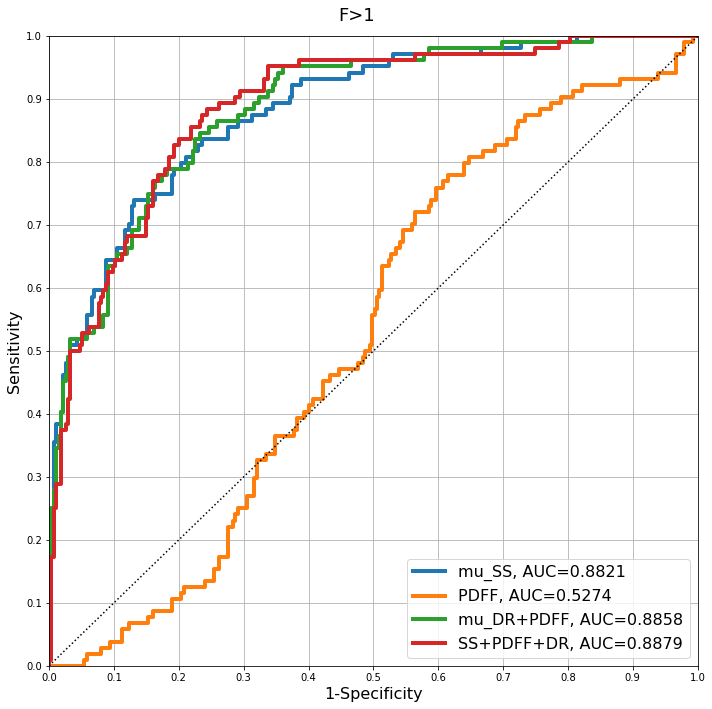

In [15]:
best={'Fib_gt1':['SS','FF','SSFF','SSFFDR']}
models={'SS':['mu_SS'],
        'FF':['PDFF'],
        'SSFF':['mu_DR','PDFF'],
        'SSFFDR':['SS','PDFF','DR']}

fibinf_fig = plt.figure(figsize=(10,10))
fibinf_fig.add_subplot()
roc_plot(fibinf_fig,data1,'Fib_gt1',best['Fib_gt1'],models,'F>1')
# nas_fig.savefig('./nas_prediction_test.svg', format='svg')

In [17]:
fibinf_fig.savefig('./fibrosis/fibgt1.svg', format='svg', bbox_inches=[])
# fibinf_fig.savefig('./fibrosis/fib_infl.svg', format='svg', bbox_inches=[])

In [ ]:
#BEST MODELS
# best = {'Fib_gt0':['S','SP']}#, 'SPR','APR']}
best={'Fib_gt0':['SP','SPD','SPGr','SGrDP','SPDGdGr'], 
      'Fib_gt1':['GdD','GrP','GrD','SGdD','SPDGdGr'],
      'Fib_gt2':['SPD','SPGr','SGdD','GdGrDP'],
      'Fib_gt3':['GrD','SPD','SGdD','SGrD','GdGrD']}

In [ ]:
#Fib_le0 ROC CURVES
fible0 = plt.figure(figsize=(10,10))
fible0.add_subplot()
roc_plot(fible0,data,'Fib_gt0',best['Fib_gt0'],models,'Fib 0:1-4')
# fible0.legend()

#SAVING PLOTS
# fible0.savefig('results_woUCSD/ROCs_test_Fib_le0.tiff', format='tiff')
# fible0.savefig('results_woUCSD/ROCs_test_Fib_gt0.svg', format='svg')
# fible0.savefig('results_woUCSD/ROCs_test_Fib_gt0.png', format='png')

In [ ]:
#Fib_le1 ROC CURVES
fible1 = plt.figure(figsize=(10,10))
fible1.add_subplot()
roc_plot(fible1,data,'Fib_gt1',best['Fib_gt1'],models,'Fib 0-1:2-4')

#SAVING PLOTS
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.eps', format='eps')
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.svg', format='svg')
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.png', format='png')

In [ ]:
#s1 ROC CURVES
fible2 = plt.figure(figsize=(10,10))
fible2.add_subplot()
roc_plot(fible2,data,'Fib_gt2',best['Fib_gt2'],models,'Fib 0-2:3-4')

#SAVING PLOTS
# fible2.savefig('results_woUCSD/ROCs_test_Fib_le2.eps', format='eps')
# fible2.savefig('results_woUCSD/ROCs_test_Fib_gt2.svg', format='svg')
# fible2.savefig('results_woUCSD/ROCs_test_Fib_gt2.png', format='png')

In [ ]:
#s2 ROC CURVES
fible3 = plt.figure(figsize=(10,10))
fible3.add_subplot()
roc_plot(fible3,data,'Fib_gt3',best['Fib_gt3'],models,'Fib 0-3:4')

#SAVING PLOTS
# fible3.savefig('results_woUCSD/ROCs_test_Fib_le3.eps', format='eps')
# fible3.savefig('results_woUCSD/ROCs_test_Fib_gt3.svg', format='svg')
# fible3.savefig('results_woUCSD/ROCs_test_Fib_gt3.png', format='png')

### Final Model Training

In [ ]:
#INITIALIZATION
clfs={target:{model:LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver,tol=tol,max_iter=max_iter,
                                         class_weight=class_weight) for model in models} for target in targets}

# final_cols=['target','model','AUC','intercept',
#             'beta_S','beta_SP','beta_std_S',
#             'beta_std_SP','OR_std_S','OR_std_SP']
model_keys = {'SS':['SS'],'FF':['FF'],'SSFF':['SS','FF'],
              'SSFFDR':['SS','FF','DR'],'SSFFGi':['SS','FF','Gi']}
final_cols=['target','model','AUC','intercept',
            'beta_SS','beta_DR','beta_FF','beta_Gi','beta_Gd',
            'beta_std_SS','beta_std_DR','beta_std_FF','beta_std_Gi',
            'beta_std_Gd','OR_std_SS','OR_std_DR','OR_std_FF','OR_std_Gi','OR_std_Gd']
final=pd.DataFrame(columns=final_cols)

In [ ]:
#FINAL TRAINING
# cutoffs=np.linspace(1,0,1001)
k=0
for target in targets:
    for model in models:
        final.loc[k,'target']=target
        final.loc[k,'model']=model
        
        #Cross Validated Training
        X=data[models[model]]
        Y=data[target]
        clfs[target][model].fit(X,Y)
        
        #Checking AUC
        Y_proba=clfs[target][model].predict_proba(X)[:,1]
#         pos = Y.sum()
#         neg = len(data)-pos
        
#         cutoff = fnr_cutoff(cutoffs, Y_proba, Y, pos, 0.05)
#         final.loc[k,'cutoff']= cutoff[0]
                
        #Computing Specificity at cutoff
#         final.loc[k,'spec']=cutoff[1]/neg
        
        #Computing AUC
        final.loc[k,'AUC']=roc_auc_score(Y,Y_proba)
        
        #Getting Intercept
        final.loc[k,'intercept']=clfs[target][model].intercept_[0]
        
        #Getting Coefficients
        coefs=clfs[target][model].coef_[0]
        for i,coef in enumerate(coefs):
            final.loc[k,f'beta_{model_keys[model][i]}']=coef
            final.loc[k,f'beta_std_{model_keys[model][i]}']=\
            final.loc[k,f'beta_{model_keys[model][i]}']*(X[models[model][i]].std())
            final.loc[k,f'OR_std_{model_keys[model][i]}']=\
            np.exp(final.loc[k,f'beta_std_{model_keys[model][i]}'])
        
        #Saving Model
#         dump(clfs[target][model], f'3_cohorts/LRM_Fib_{target}_{model}.joblib')
#         dump(clfs[target][model], f'4_cohorts/LRM_Fib_{target}_{model}.joblib')
#         dump(clfs[target][model], f'nash/LRM_{target}_{model}.joblib')
        
        #Row Iterator
        k+=1

#SAVING RESULTS
# final.to_excel('3_cohorts/metrics_final_fibrosis.xlsx',index=False)
# final.to_excel('4_cohorts/metrics_final_fibrosis.xlsx',index=False, sheet_name='LS-3D-60')

# outname = '4_cohorts/metrics_final_fibrosis.xlsx'
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'w', [final], 'mre_60Hz', False)

In [ ]:
final

#### Screening Fib > 0

In [ ]:
no_fib = data[data['Fibrosis']==0]
yes_fib = data[data['Fibrosis']>0]
cols = ['Steatosis','Inflammation']
rows = ['Fib==0','Fib>0']

count_data = [[no_fib[no_fib['Steatosis']==0]['Steatosis'].count(),no_fib[no_fib['Inflammation']==0]['Inflammation'].count()],
              [yes_fib[yes_fib['Steatosis']>0]['Steatosis'].count(),yes_fib[yes_fib['Inflammation']>0]['Inflammation'].count()]]

steat_inf_count = pd.DataFrame(count_data, columns=cols, index=rows)
steat_inf_count.name = 'Fibrosis'
steat_inf_count
# print(f"For Fib=0, those without steatosis are {no_fib[no_fib['Steatosis']==0]['Steatosis'].count()}"
# f" and with steatosis are {no_fib[no_fib['Steatosis']>0]['Steatosis'].count()}")

# print(f"For Fib=0, those without steatosis are {yes_fib[yes_fib['Steatosis']==0]['Steatosis'].count()}"
# f" and with steatosis are {yes_fib[yes_fib['Steatosis']>0]['Steatosis'].count()}")

In [ ]:
# outname = '4_cohorts/metrics_final_fibrosis.xlsx'
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'a', [steat_inf_count], 'Fib(Steat_Inf)', True)

#### Group pouplations

In [ ]:
population = {'NASH_gt0','NASH_gt1','NAS_gt0',
              'NAS_gt1','NAS_gt2','NAS_gt3',
             'NAS_gt4','NAS_gt5','NAS_gt6'}
scores = pd.DataFrame(index=population, columns=['True','False'])

In [ ]:
count = len(population)
while count > 0:
    scores.iloc[count - 1, 0] = \
    data[data[scores.index[count-1]] == 1][scores.index[count-1]].count()
    
    scores.iloc[count - 1, 1] = \
    data[data[scores.index[count-1]] == 0][scores.index[count-1]].count()
    
    count -= 1
    
scores

In [ ]:
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'a', [scores], 'NASH_NAS populations', True)